In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

In [2]:
def plot_particle(pos, vel=[]):
    plt.scatter(*pos.T)
    if vel !=[]:
        plt.plot(np.block([pos, pos+vel])[:, ::2].T, np.block([pos, pos+vel])[:, 1::2].T, c='blue')
    plt.xlim(0,1)
    plt.ylim(0,1)
    

In [ ]:
# スキーム
def calculate_distance_matrix(pos):
    n_sample, dim = pos.shape
    
    distance_mtx = np.zeros([n_sample, n_sample])
    for i in range(n_sample):
        for j in range(n_sample):
            dist = np.linalg.norm(pos[i] - pos[j])
            distance_mtx[i,j] = dist
    
    return distance_mtx


def calculate_weight_matrix(pos, r_e):
    n_sample, dim = pos.shape
    
    distance_mtx = calculate_distance_matrix(pos)
    weight_mtx = np.where((distance_mtx < r_e)&(distance_mtx > 0), r_e / distance_mtx - 1, 0)
    
    return weight_mtx


def calculate_laplacian(val, n_0, lambda_0, weight=1):
    if len(val.shape) == 1:
        val = val.reshape(-1,1)
    n_sample, dim = val.shape
    
    laplacian = np.empty([n_sample, dim])
    for i, v in enumerate(val):
        w = np.repeat([weight[i]], dim, axis=0).T
        laplacian[i] = (2*dim)/(lambda_0*n_0) * sum((v - val)* w)
        
    return laplacian

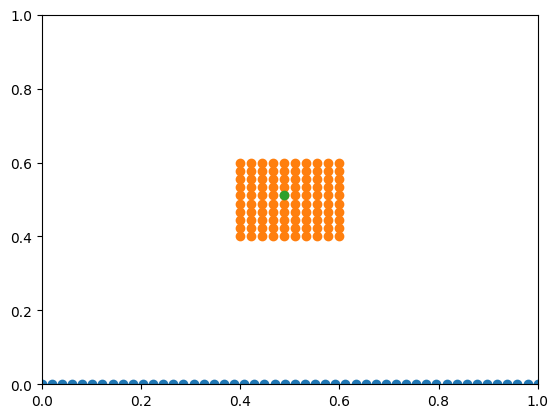

In [9]:
# 初期条件
### 固定壁
x = np.linspace(0, 1, 50)
y = np.linspace(0, 0, 50)
pos_rigid = np.block([[x], [y]]).T
vel_rigid = np.zeros((50, 2))

### 水柱
x = np.linspace(0.4, 0.6, 10)
y = np.linspace(0.4, 0.6, 10)
xx, yy = np.meshgrid(x, y)

pos_water = np.block([[xx.flatten()], [yy.flatten()]]).T
n_sample, dim = pos_water.shape
vel_water = np.zeros([n_sample, dim])

# 結合
pos_rigid.shape, pos_water.shape
pos = np.block([[pos_rigid], [pos_water]])
vel = np.block([[vel_rigid], [vel_water]])
n_sample, dim = pos.shape

# 描画
plot_particle(pos_rigid)
plot_particle(pos_water)

representive_index = 104
plot_particle(pos[representive_index]) # 代表位置


In [17]:
### 解析条件
#時間 
dT = 0.01
t_max = 3

# パラメータ
r_e = 0.2
nu = 0.1
rho = 1000
g = [0, -9.80665]

# 初期点群の距離，重みの計算
init_distance_mtx = calculate_distance_matrix(pos)
init_weight_mtx = calculate_weight_matrix(pos, r_e)

# 各点の粒子数密度，分散
n_ = np.sum(init_weight_mtx, axis=1)
lambda_ =  np.sum(init_distance_mtx * init_weight_mtx, axis=1) / np.sum(init_weight_mtx, axis=1)

# 代表点での粒子数密度，分散を保存条件に用いる
n_0 = n_[representive_index]
lambda_0 = lambda_[representive_index]


# 時系列
timeseries = np.arange(0, t_max, dT)
pos_timeseries = np.empty([len(timeseries), n_sample, dim])

for ind, t in enumerate(timeseries):
    # 保存
    pos_timeseries[ind] = pos
    
    # 重みの計算
    weight_mtx = calculate_weight_matrix(pos, r_e)
    
    # 粘性項の計算
    du_dxx = calculate_laplacian(vel, n_0, lambda_0, weight_mtx)

    # 仮の流速と，粒子数密度
    vel_tentative = vel + dT * (nu * du_dxx + g)
    w_star = calculate_weight_matrix(pos, r_e)
    n_star = np.sum(w_star, axis=1)
    
    # 圧力の計算
    ## ポアソン式の右項
    b = rho / dT**2 * (n_star - n_0) / n_0 
    ## ポアソン式を満たすPを陰的に解く(一点ずつ)
    #FIXME: fsolveが動かない。おそらくfsolveが1次元の入力しか扱えないのに対して，calculate_laplacianの出力が2次元となっているため？
    p = []
    solv = fsolve(lambda x: calculate_laplacian(x, n_0, lambda_0, w_star) - b, np.zeros([n_sample,1]))
    
    
    # 位置を修正
    pos += dT * vel    


/tmp/ipykernel_3597583/1196963205.py:18: RuntimeWarning: divide by zero encountered in divide
  weight_mtx = np.where((distance_mtx < r_e)&(distance_mtx > 0), r_e / distance_mtx - 1, 0)
/tmp/ipykernel_3597583/1196963205.py:18: RuntimeWarning: divide by zero encountered in divide
  weight_mtx = np.where((distance_mtx < r_e)&(distance_mtx > 0), r_e / distance_mtx - 1, 0)


TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument '<lambda>'.Shape should be (150,) but it is (150, 150).

In [ ]:
for i in range(0, 300, 50):
    print(pos_timeseries[i, 1])

[0.42222222 0.4       ]
[0.47222222 0.45      ]
[0.52222222 0.5       ]
[0.57222222 0.55      ]
[0.62222222 0.6       ]
[0.67222222 0.65      ]


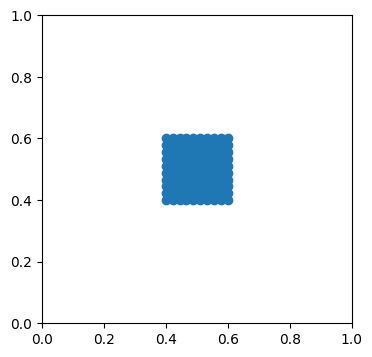

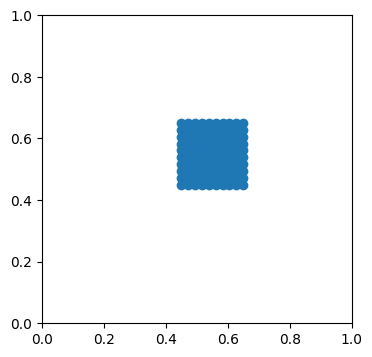

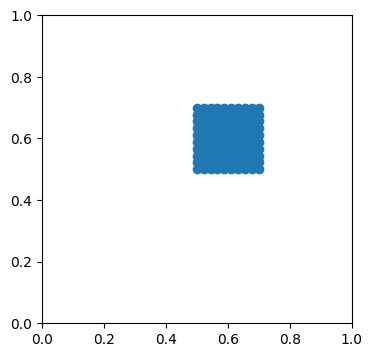

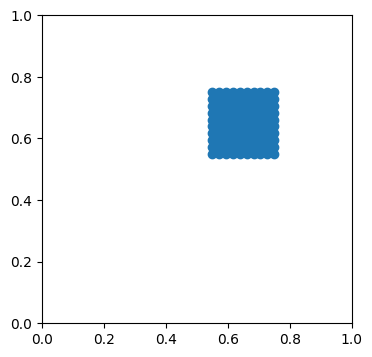

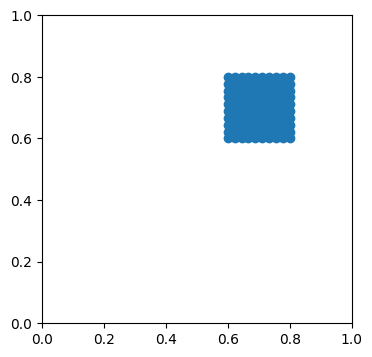

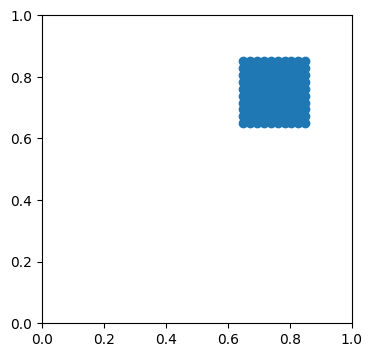

In [ ]:
for i in range(0, 300, 50):
    plot_particle(pos_timeseries[i])